<a href="https://colab.research.google.com/github/azizhina51-svg/NLP/blob/main/time_series_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Option A: local CSV
# DATA_PATH = "daily_temperature.csv"

# Option B: raw GitHub URL (example)
DATA_PATH = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


<Axes: title={'center': 'Temperature time series'}, xlabel='Date'>

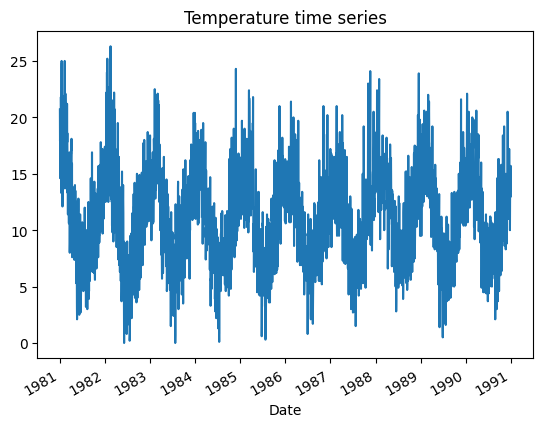

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')

# Rename 'Temp' to 'temperature'
df = df.rename(columns={'Temp':'temperature'})
series = df['temperature'].astype(float)
series.plot(title='Temperature time series')

Start: 1981-01-01 00:00:00 End: 1990-12-31 00:00:00
Missing values: 0


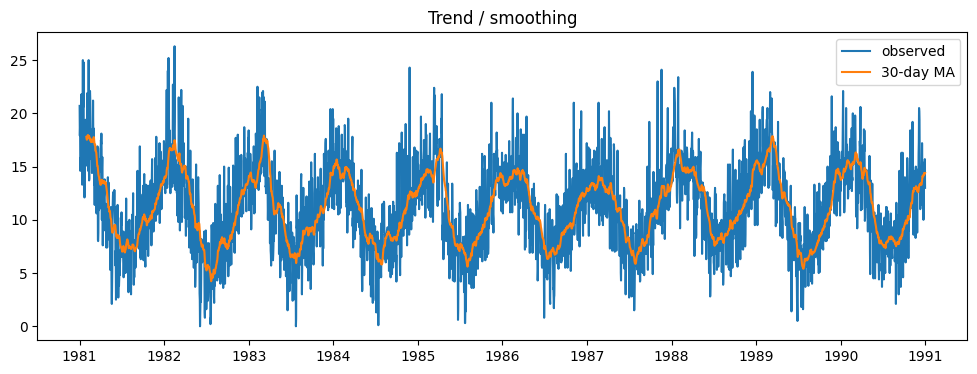

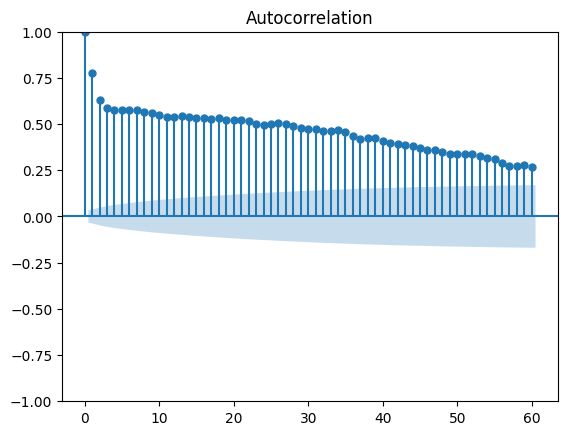

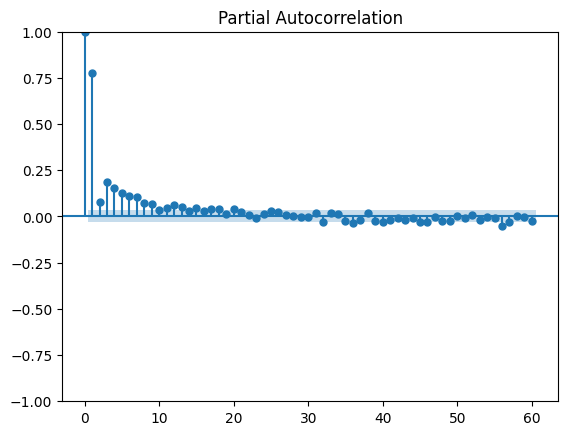

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("Start:", series.index.min(), "End:", series.index.max())
print("Missing values:", series.isna().sum())

# Fill or interpolate if needed (simple)
series = series.interpolate(method='time')

# Rolling mean & std
plt.figure(figsize=(12,4))
plt.plot(series, label='observed')
plt.plot(series.rolling(30).mean(), label='30-day MA')
plt.legend()
plt.title('Trend / smoothing')
plt.show()

# Autocorrelation
plot_acf(series.dropna(), lags=60)
plt.show()
plot_pacf(series.dropna(), lags=60)
plt.show()


In [ ]:
# Example: last 365 days as test
n_test = 365
train = series[:-n_test]
test = series[-n_test:]

print(len(train), len(test))


3285 365


In [ ]:
import numpy as np
def naive_forecast(train, test):
    preds = test.copy()
    preds[:] = np.nan
    for i in range(len(test)):
        preds.iloc[i] = train.iloc[-1] if i==0 else test.iloc[i-1]
    return preds

naive_preds = naive_forecast(train, test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return {'MAE': mae, 'RMSE': rmse}

print("Naive:", metrics(test, naive_preds))


Naive: {'MAE': 2.024931506849315, 'RMSE': np.float64(2.5824009217292243)}


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1,1))


In [ ]:
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 30
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)

# Prepare test sequences (use last part of train + test)
combined = np.vstack([train_scaled, test_scaled])
X_all, y_all = create_sequences(combined, SEQ_LEN)
start = len(train_scaled) - SEQ_LEN
X_test = X_all[start: start + len(test)]
y_test = y_all[start: start + len(test)]


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es])


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0374 - val_loss: 0.0097
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0116 - val_loss: 0.0092
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0114 - val_loss: 0.0088
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0108 - val_loss: 0.0086
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0106 - val_loss: 0.0083
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0108 - val_loss: 0.0079
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0095 - val_loss: 0.0072
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0098 - val_loss: 0.0070
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0095 - val_loss: 0.0069
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step

In [42]:
preds_scaled = model.predict(X_test).ravel()
preds = scaler.inverse_transform(preds_scaled.reshape(-1,1)).ravel()
lstm_forecast = pd.Series(preds, index=test.index)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return {'MAE': mae, 'RMSE': rmse}

print("LSTM Forecast:", metrics(test, lstm_forecast))


LSTM Forecast: {'MAE': 1.751057044512605, 'RMSE': np.float64(2.271710064209648)}


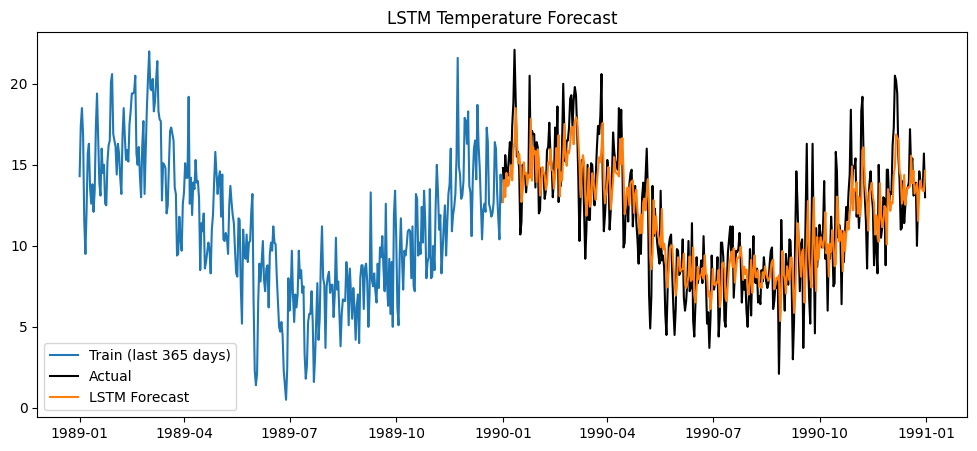

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train[-365:], label='Train (last 365 days)')
plt.plot(test, label='Actual', color='black')
plt.plot(lstm_forecast, label='LSTM Forecast')
plt.legend()
plt.title('LSTM Temperature Forecast')
plt.show()
